In [1]:
import pandas as pd
import numpy as np
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import Imputer
import sys
sys.path.append('icd9')
from icd9 import ICD9
import re
import pickle
import seaborn as sns
import pylab
from scipy.cluster.hierarchy import dendrogram, linkage
sns.set()

In [2]:
with open('clean_data/df.pkl', 'rb') as f:
        df = pickle.load(f)
with open('clean_data/df_labels.pkl', 'rb') as f:
        df_labels = pickle.load(f)

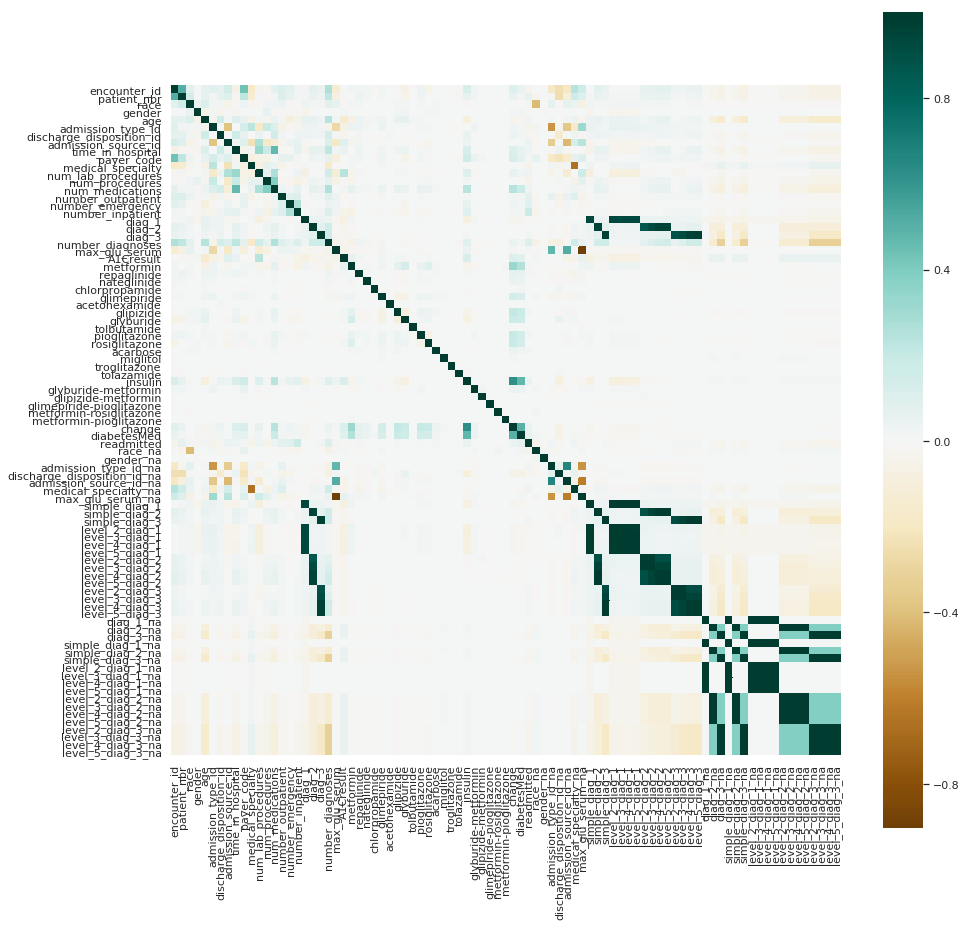

In [3]:
corr = df.corr()
fig, ax = plt.subplots(figsize=(15,15)) 
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        square=True,
        ax=ax,
        center=0,
        cmap='BrBG')

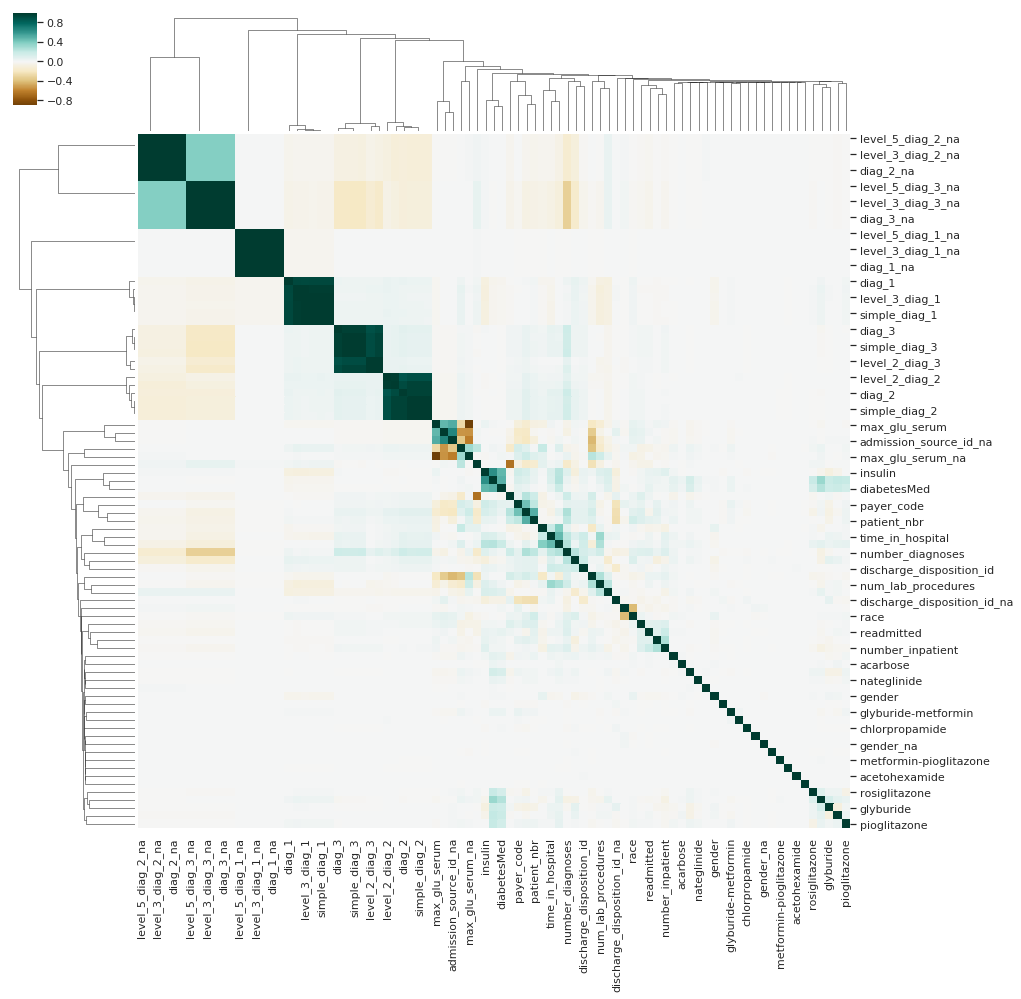

In [14]:
sns.clustermap(corr,
        center=0,
        cmap='BrBG',
        figsize=(15, 15))

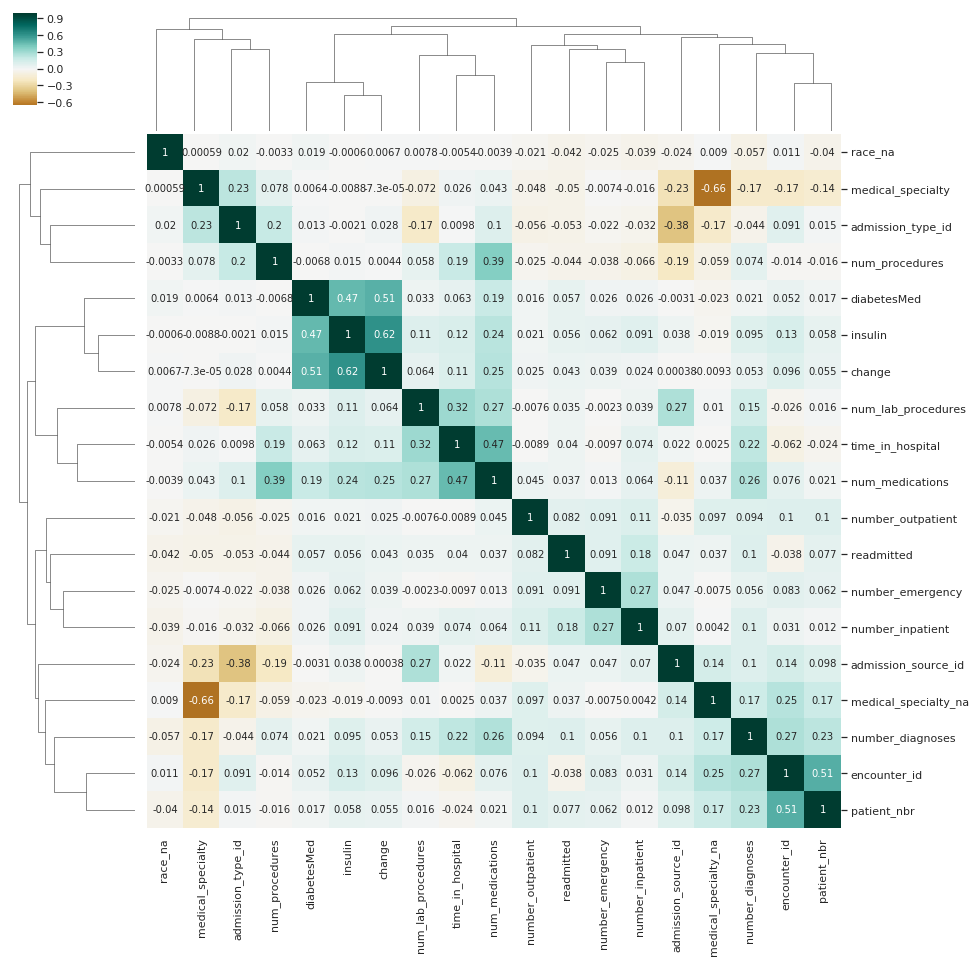

In [22]:
corr_thresh = 0.035
df_correlated = df.loc[:, ((corr.readmitted.sort_values()<-corr_thresh) | (corr.readmitted.sort_values()>corr_thresh))]
corr_high = df_correlated.corr()
p = sns.clustermap(corr_high,
        square=True,
        center=0,
        cmap='BrBG',
        annot=True,
        figsize=(15, 15))